In [7]:
!pip install dataprep flaml[notebook] xlrd openpyxl
import pandas as pd


In [8]:
from flaml import AutoML

ModuleNotFoundError: No module named 'flaml'

In [9]:
workbook = pd.ExcelFile('locust_test_result.xlsx',engine='openpyxl')
sheets= workbook.sheet_names
sheets

['result_t2_large',
 'result_t2_xlarge',
 'result_m5_xlarge',
 'result_m5_2xlarge',
 'result_m5_4xlarge',
 'result_m4_xlarge']

In [36]:
df = pd.concat([pd.read_excel(workbook, sheet_name=s).assign(instance_type=s) for s in sheets],ignore_index=True)
first_column = df.pop('instance_type')
one_hot=pd.get_dummies(first_column)
df= df.join(one_hot)
df.columns

Index([                       'user',                  ' blocksize',
                         'Timestamp',                  'User Count',
                              'Type',                        'Name',
                        'Requests/s',                  'Failures/s',
                                 0.5,                          0.66,
                                0.75,                           0.8,
                                 0.9,                          0.95,
                                0.98,                          0.99,
                               0.999,                             1,
               'Total Request Count',         'Total Failure Count',
        'Total Median Response Time',     'Total Min Response Time',
           'Total Max Response Time',  'Total Average Content Size',
                      'cpu_measured',                 ' thread_num',
                      ' cpu_compute',                        0.9999,
       'Total Average Response Tim

In [37]:
row_filtered = df[df['user'] == 'user'].index
col_filtered = df[pd.isna(df[0.5])].index
df_clean=df.drop(row_filtered)
df_clean=df_clean.drop(col_filtered).reset_index()
df_clean[' blocksize']=(df_clean[' blocksize'].str.replace(r'mb', '000000'))
df_clean[' blocksize']=(df_clean[' blocksize'].str.replace(r'kb', '000'))
df_clean[' blocksize']=pd.to_numeric(df_clean[' blocksize'])
#df_clean[' blocksize']=pd.to_numeric(df_clean[' blocksize'].str.replace(r'mb$', '000000'))

df_clean[' blocksize']

0         10000
1         10000
2         10000
3         10000
4         10000
         ...   
2901    1000000
2902    1000000
2903    1000000
2904    1000000
2905    1000000
Name:  blocksize, Length: 2906, dtype: int64

In [38]:
from dataprep.eda import create_report

for col in ['cpu_measured', 'Total Average Response Time','Requests/s',0.999]:
    df_clean[col] = pd.to_numeric(df_clean[col])
    df_clean[col]= (df_clean[col]-df_clean[col].mean())/df_clean[col].std()

report= create_report(df_clean)


  0%|          | 0/4814 [00:00<?, ?it/s]

In [41]:
''' import AutoML class from flaml package '''
import sys
sys.path.append('/home/nick/pkb/lib/python3.8/site-packages/')
from flaml import AutoML
automl = AutoML()
settings = {
    "time_budget": 30,  # total running time in seconds
    "metric": 'r2',  # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "task": 'regression',  # task type    
    "log_file_name": 'bops_experiment.log',  # flaml log file
}
df_X=df_clean[['result_m5_2xlarge','result_m5_2xlarge','result_m5_xlarge','result_t2_xlarge','result_m4_xlarge','result_m5_4xlarge','result_t2_large','User Count',' blocksize','cpu_measured','Total Request Count']]
df_X=df_X.to_numpy()
df_Y=df_clean[['Total Average Response Time']].to_numpy()


In [42]:
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'r2',  # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "task": 'regression',  # task type    
    "log_file_name": 'bops_experiment.log',  # flaml log file
}

In [43]:
'''The main flaml automl API'''
automl.fit(X_train=df_X[0:1500],y_train=df_Y[0:1500], **settings)

[flaml.automl: 07-04 22:54:18] {908} INFO - Evaluation method: cv
Evaluation method: cv
[flaml.automl: 07-04 22:54:18] {617} INFO - Using RepeatedKFold
Using RepeatedKFold
[flaml.automl: 07-04 22:54:18] {929} INFO - Minimizing error metric: 1-r2
Minimizing error metric: 1-r2
[flaml.automl: 07-04 22:54:18] {948} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
[flaml.automl: 07-04 22:54:18] {1012} INFO - iteration 0, current learner lgbm
iteration 0, current learner lgbm
[flaml.automl: 07-04 22:54:18] {1159} INFO -  at 0.1s,	best lgbm's error=0.7602,	best lgbm's error=0.7602
 at 0.1s,	best lgbm's error=0.7602,	best lgbm's error=0.7602
[flaml.automl: 07-04 22:54:18] {1012} INFO - iteration 1, current learner lgbm
iteration 1, current learner lgbm
[flaml.automl: 07-04 22:54:18] {1159} INFO -  at 0.1s,	best lgbm's error=0.7602,	best lgbm's error=0.7602
 at 0.1

In [44]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 30.0, 'max_features': 1.0}
Best accuracy on validation data: 0.9812
Training duration of best run: 0.8024 s


In [45]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [46]:
''' compute predictions of testing dataset ''' 
y_test=df_Y[1501:2000]
y_pred = automl.predict(df_X[1501:2000])
print('Predicted labels-True labels', y_pred-y_test)
#print('True labels', y_test)

Predicted labels-True labels [[ 3.88535241e-03  3.88535241e-03  3.00806499e-03 ...  4.38830275e-04
   4.38830275e-04  1.44296004e-04]
 [ 3.88535241e-03  3.88535241e-03  3.00806499e-03 ...  4.38830275e-04
   4.38830275e-04  1.44296004e-04]
 [ 4.15429294e-03  4.15429294e-03  3.27700552e-03 ...  7.07770802e-04
   7.07770802e-04  4.13236531e-04]
 ...
 [ 3.48861058e-03  3.48861058e-03  2.61132316e-03 ...  4.20884409e-05
   4.20884409e-05 -2.52445831e-04]
 [ 3.48861058e-03  3.48861058e-03  2.61132316e-03 ...  4.20884409e-05
   4.20884409e-05 -2.52445831e-04]
 [ 3.58265350e-03  3.58265350e-03  2.70536608e-03 ...  1.36131362e-04
   1.36131362e-04 -1.58402909e-04]]


In [47]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 1500, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 1500, 'Current Hyper-parameters': {'n_estimators': 4.0, 'num_leaves': 4.0, 'min_child_samples': 12.0, 'learning_rate': 0.25912534572860507, 'subsample': 0.9266743941610592, 'log_max_bin': 10.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0013933617380144255, 'reg_lambda': 0.18096917948292954}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4.0, 'num_leaves': 4.0, 'min_child_samples': 12.0, 'learning_rate': 0.25912534572860

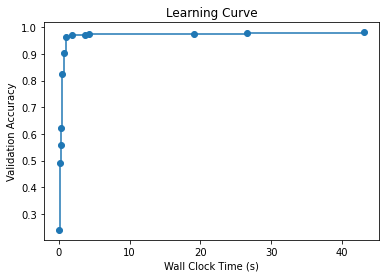

In [49]:
import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()